In [101]:
import networkx as nx
import numpy as np
import pathlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn import metrics


In [7]:
base_dir = pathlib.Path().cwd().parent
data_dir = base_dir / 'data' / 'raw'
processed_data_dir = base_dir / 'data' / 'processed'

RETWEET_GRAPH_FILENAME = 'lcc_retweet.gml'
USER_LABELS_FILENAME = 'lcc_retweet_labels.npy'


In [8]:
retweet_network_lcc = nx.read_graphml(processed_data_dir / RETWEET_GRAPH_FILENAME)
user_labels = np.load(processed_data_dir / USER_LABELS_FILENAME)


# Baseline 1: Edge filtering method

In [55]:
node_ids_list = list(retweet_network_lcc.nodes())
# Relabel each node from 0 to N-1
node_remapping = {node_ids_list[i]: i for i in range(len(node_ids_list))}
retweet_network_lcc = nx.relabel_nodes(retweet_network_lcc, node_remapping)

# Make edge weights of float type
for u,v,d in retweet_network_lcc.edges(data=True):
    d['weight'] = float(d['weight'])
    

In [94]:
weights_list = [attrs["weight"] for _, _, attrs in retweet_network_lcc.edges(data=True)]
unique_weights = sorted(list(set(weights_list)))


In [100]:
predicted_labels_list = []
for weight_percentile in tqdm(np.arange(0, 100, 0.5)):
    weight_threshold = np.percentile(weights_list, weight_percentile)
    G = retweet_network_lcc.copy()
    predicted_labels = np.full(shape=G.number_of_nodes(), fill_value=1)
    G.remove_edges_from([(a,b) for a, b, attrs in G.edges(data=True) if float(attrs["weight"]) <= weight_threshold])
    legitimate_users = [int(i) for i in nx.isolates(G)]
    if len(legitimate_users) > 0:
        predicted_labels[legitimate_users] = 0
    predicted_labels_list.append(np.copy(predicted_labels))
    

  0%|          | 0/200 [00:00<?, ?it/s]

In [85]:
metrics_dict = {'f1_macro': [], 
                'f1_micro': [], 
                'accuracy': [],
                'precision': []}
for i in tqdm(range(len(predicted_labels_list))):
    metrics_dict['f1_macro'].append(metrics.f1_score(user_labels, predicted_labels_list[i], average='macro'))
    metrics_dict['f1_micro'].append(metrics.f1_score(user_labels, predicted_labels_list[i], average='micro'))
    metrics_dict['accuracy'].append(metrics.accuracy_score(user_labels, predicted_labels_list[i]))
    metrics_dict['precision'].append(metrics.precision_score(user_labels, predicted_labels_list[i]))




  0%|          | 0/1001 [00:00<?, ?it/s]

/home/minici/anaconda3/envs/gfm_io/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


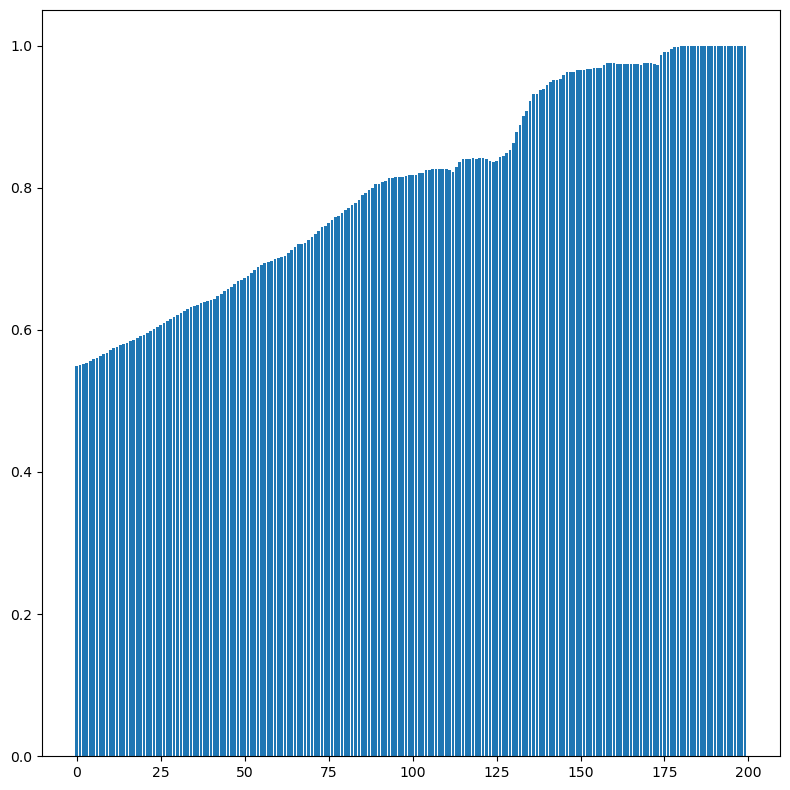

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.bar(x=range(len(predicted_labels_list)), height=metrics_dict['precision'])
fig.tight_layout()


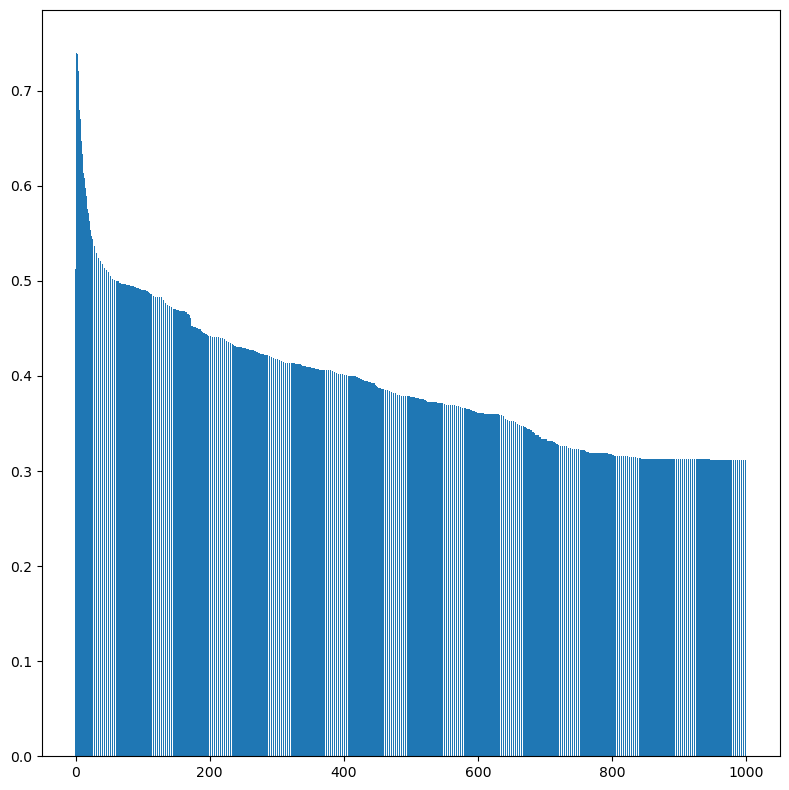

In [88]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.bar(x=range(len(predicted_labels_list)), height=metrics_dict['f1_macro'])
fig.tight_layout()


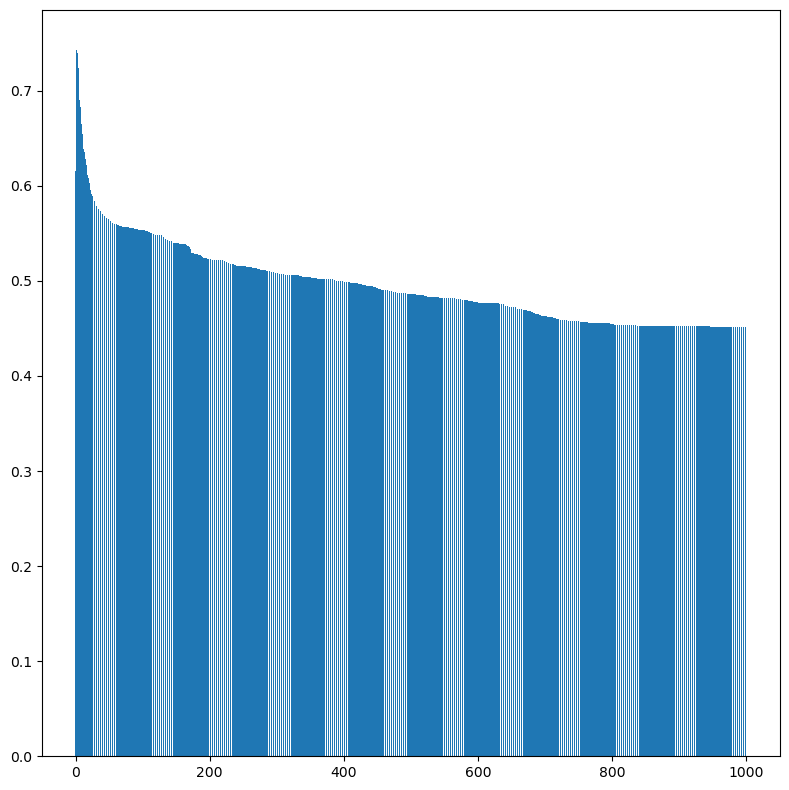

In [93]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.bar(x=range(len(predicted_labels_list)), height=metrics_dict['accuracy'])
fig.tight_layout()


# Baseline 2: Node pruning method

In [107]:
centrality_values = nx.eigenvector_centrality(retweet_network_lcc)
# Transform into a list
centrality_val_list = [-1]*retweet_network_lcc.number_of_nodes()
for node_id in tqdm(centrality_values):
    centrality_val_list[node_id] = centrality_values[node_id]
centrality_val_list = np.array(centrality_val_list)


  0%|          | 0/5788 [00:00<?, ?it/s]

In [109]:
predicted_labels_list = []
for percentile in tqdm(np.arange(0, 100, 0.5)):
    centrality_threshold = np.percentile(centrality_val_list, percentile)
    predicted_labels = np.full(shape=retweet_network_lcc.number_of_nodes(), fill_value=1)
    coordinated_users = np.where(centrality_val_list <= centrality_threshold)[0]
    predicted_labels[coordinated_users] = 0
    predicted_labels_list.append(np.copy(predicted_labels))
    

  0%|          | 0/200 [00:00<?, ?it/s]

In [110]:
metrics_dict = {'f1_macro': [], 
                'f1_micro': [], 
                'accuracy': [],
                'precision': []}
for i in tqdm(range(len(predicted_labels_list))):
    metrics_dict['f1_macro'].append(metrics.f1_score(user_labels, predicted_labels_list[i], average='macro'))
    metrics_dict['f1_micro'].append(metrics.f1_score(user_labels, predicted_labels_list[i], average='micro'))
    metrics_dict['accuracy'].append(metrics.accuracy_score(user_labels, predicted_labels_list[i]))
    metrics_dict['precision'].append(metrics.precision_score(user_labels, predicted_labels_list[i]))




  0%|          | 0/200 [00:00<?, ?it/s]

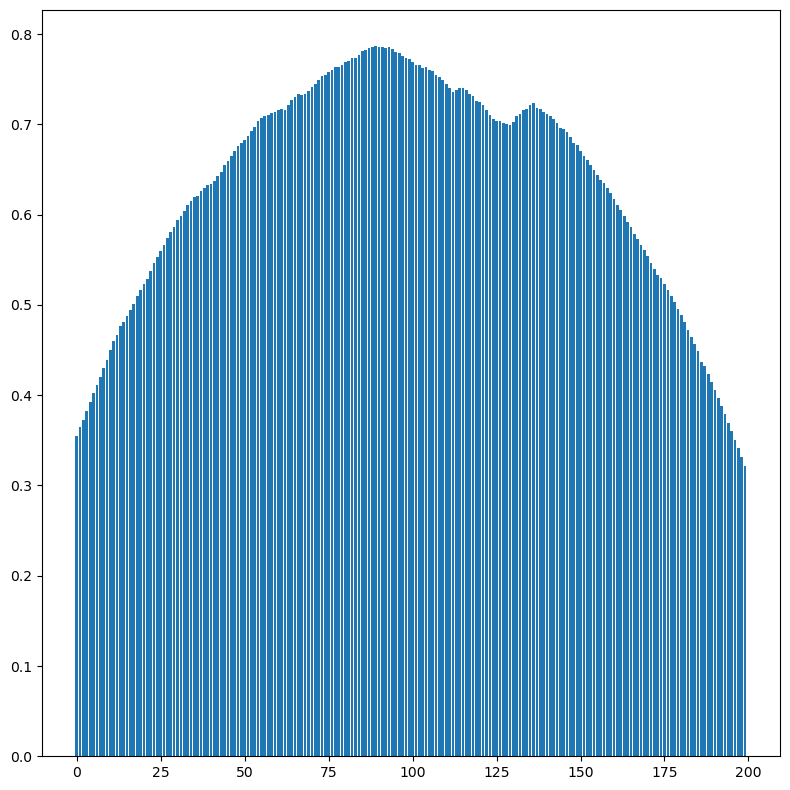

In [111]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.bar(x=range(len(predicted_labels_list)), height=metrics_dict['f1_macro'])
fig.tight_layout()


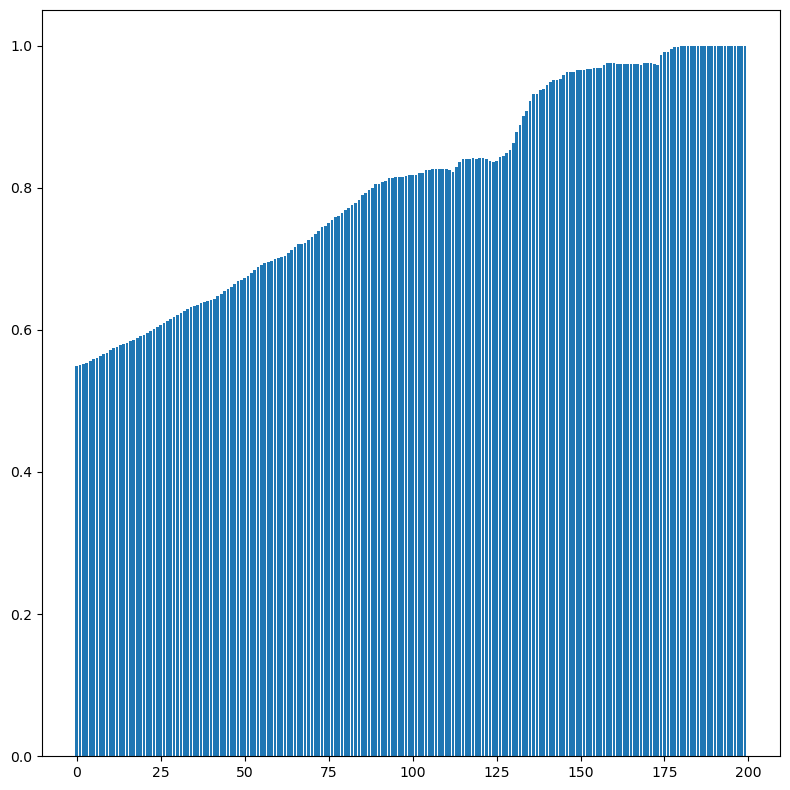

In [112]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.bar(x=range(len(predicted_labels_list)), height=metrics_dict['precision'])
fig.tight_layout()


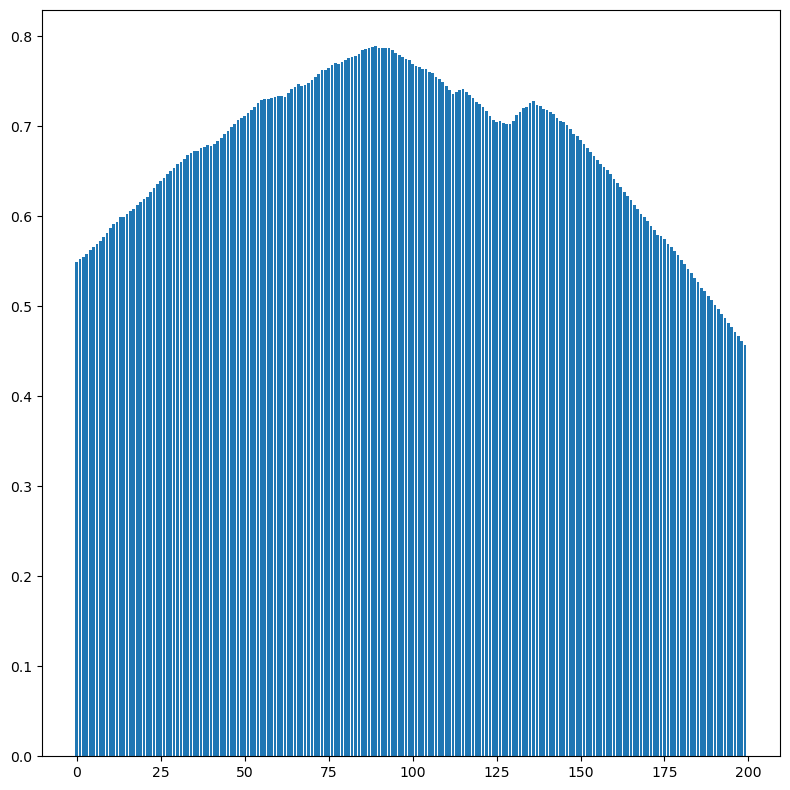

In [114]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.bar(x=range(len(predicted_labels_list)), height=metrics_dict['accuracy'])
fig.tight_layout()
